In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.optim as optim

torch.autograd.set_detect_anomaly(True)


In [2]:
class NeuralNet(nn.Module):
    """
    Neural Network class for regression, again is taken from the tutorial
    """

    def __init__(
        self, input_dimension, output_dimension, n_hidden_layers, neurons, retrain_seed
    ):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain("tanh")
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

-------
## Model 2
Trying different architecture with the just one network 

In [160]:
class Pinn_inverse_problem_2:
    # write documentation of this class in pytorch style
    """
    Class to solve the inverse problem of the thermal storage with a source term using a physics-informed neural network

    Parameters
    ----------
    n_int_ : int
        Number of interior points
    n_sb_ : int
        Number of spatial boundary points
    n_tb_ : int
        Number of temporal boundary points
    path_to_data : str
        Path to the data file containing the measured data
    T_0 : float
        Initial temperature
    T_hot : float
        Hot temperature
    T_cold : float
        Cold temperature
    alpha_f : float
        Thermal diffusivity
    h_f : float
        Heat transfer coefficient
    lambda_u : float    
        Parameter to balance role of data and PDE

        
    Attributes
    ----------
    (same as parameters)
    self.domain_extrema : torch.tensor
        Extrema of the solution domain (t,x) in [0,8] x [0,1]
    self.space_dimensions : int
        Number of space dimensions
    self.approximate_Tf_Ts : NeuralNet  
        FF Dense NN to approximate the solution of both Tf and Ts
    self.soboleng : torch.quasirandom.SobolEngine
        Generator of Sobol sequences
    self.training_set_sb_l : torch.utils.data.DataLoader
        Training set S_sb_l corresponding to the spatial boundary
    self.training_set_sb_r : torch.utils.data.DataLoader
        Training set S_sb_r corresponding to the spatial boundary
    self.training_set_tb : torch.utils.data.DataLoader
        Training set S_tb corresponding to the temporal boundary
    self.training_set_int : torch.utils.data.DataLoader
        Training set S_int corresponding to the interior domain where the PDE is enforced

        
    Methods
    -------
    convert(tens)
        Linearly transform a tensor whose value are between 0 and 1 to a tensor whose values are between the domain extrema
    add_temporal_boundary_points()
        Return the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    add_spatial_boundary_points_left()
        Return the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    add_spatial_boundary_points_right()
        Return the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    add_interior_points()
        Return the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    get_measurement_data()
        Get measured T_f data (given as .txt file) to be used as training data and return then as a torch tensor
    get_U_f(input_tensor)
        Given a 2D input tensor of size n_elementsx2, where the first column has values in [0,8] and the second column in [0,1], this function returns a vector of size n_elementsx1 with the following mapping:
        +1: If the corresponding value in the first column is in [0,1] or [4,5]
        -1: If the corresponding value in the first column is in [2,3] or [6,7]
        0:  Otherwise
    apply_initial_condition(input_tb)
        Compute the terms required in the definition of the TEMPORAL boundary residual
    apply_boundary_conditions_l(input_sb_l)
        Compute the terms required in the definition of the SPATIAL boundary residual
    apply_boundary_conditions_r(input_sb_r)
        Compute the terms required in the definition of the SPATIAL boundary residual
    compute_pde_residual(input_int)
        Compute the PDE residuals
    compute_loss(inp_train_sb_l, u_train_sb_l, inp_train_sb_r, u_train_sb_r, inp_train_tb, u_train_tb, inp_train_int, u_train_int, verbose=True)    
        Compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    fit(num_epochs, optimizer, verbose=True)
        Fit the model
    plot_training_points(points_size = 1)
        Plot the training points
    plot_solution(n_points=10000)
        Plot the solution T_f and compare with the measurements of T_f
    """
    def __init__(self, n_int_, n_sb_, n_tb_, path_to_data, T_0, T_hot, T_cold, alpha_f, h_f, lambda_u = 10):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.T_0  = T_0
        self.T_hot = T_hot
        self.T_cold = T_cold
        self.alpha_f = alpha_f
        self.h_f = h_f
        self.path_to_data = path_to_data

        # Extrema of the solution domain (t,x) in [0,8] x [0,1]
        self.domain_extrema = torch.tensor(
            [[0, 8], # Time dimension 
             [0, 1]]  # Space dimension
        ) 

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = lambda_u

        # FF Dense NN to approximate the solution of both Tf and Ts
        # the first ouput is the approximation of Tf and the second output is the approximation of Ts
        self.approximate_Tf_Ts = NeuralNet(
            input_dimension=self.domain_extrema.shape[0],
            output_dimension=2,
            n_hidden_layers=7,
            neurons=45,
            retrain_seed=42,
        )

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(
            dimension=self.domain_extrema.shape[0]
        )

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb_l, self.training_set_sb_r, self.training_set_tb, self.training_set_int = (
            self.assemble_datasets()
        )

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert tens.shape[1] == self.domain_extrema.shape[0]
        return (
            tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0])
            + self.domain_extrema[:, 0]
        )

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.full(input_tb[:, 1].shape, self.T_0)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points_left(self):
        # We have two cycles of:  Charging -> Idle -> Discharging -> Idle
        # we divide the conditios in 4 parts for each side of the domain
        x0 = self.domain_extrema[1, 0]
        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        output_sb_0 = torch.full(input_sb_0[:,1].shape, 0)
        output_sb_0 = torch.where(input_sb[:, 0] < 1, self.T_hot, output_sb_0)
        output_sb_0 = torch.where(
            (input_sb[:, 0] >= 4) & (input_sb[:, 0] < 5), self.T_hot, output_sb_0
        )

        return input_sb_0, output_sb_0

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points_right(self):
        xL = self.domain_extrema[1, 1]
        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_L = torch.full((input_sb.shape[0],), 0)  
        output_sb_L = torch.where(
            (input_sb[:, 0] >= 2) & (input_sb[:, 0] < 3), self.T_cold, output_sb_L
        )
        output_sb_L = torch.where(
            (input_sb[:, 0] >= 6) & (input_sb[:, 0] < 7), self.T_cold, output_sb_L
        )

        return input_sb_L, output_sb_L

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    def get_measurement_data(self):
        '''
        Function to get measured T_f data (given as .txt file) to be used as training data 
        and return then as a torch tensor
        '''

        # Read the data from the .txt file
        data = pd.read_csv(self.path_to_data)
        data = torch.tensor(data.values, dtype=torch.float32)

        input_meas = data[:, :2]
        output_meas = data[:, 2]

        return input_meas, output_meas

    def get_U_f(self, input_tensor):
        """
        Given a 2D input tensor of size n_elementsx2, where the first column has values in [0,8]
        and the second column in [0,1], this function returns a vector of size n_elementsx1 with the
        following mapping:

        +1: If the corresponding value in the first column is in [0,1] or [4,5]
        -1: If the corresponding value in the first column is in [2,3] or [6,7]
        0:  Otherwise

        Args:
        - input_tensor (torch.Tensor): Input tensor of size n_elementsx2

        Returns:
        - output_tensor (torch.Tensor): Output tensor of size n_elementsx1
        """

        # Extract the first column of the input tensor
        first_column = input_tensor[:, 0]

        # Initialize the output tensor with zeros
        output_tensor = torch.zeros_like(first_column)

        # Define the conditions and assign values accordingly
        condition_1 = (first_column >= 0) & (first_column <= 1) | (first_column >= 4) & (
            first_column <= 5
        )
        condition_2 = (first_column >= 2) & (first_column <= 3) | (first_column >= 6) & (
            first_column <= 7
        )

        output_tensor[condition_1] = 1
        output_tensor[condition_2] = -1

        return output_tensor.view(-1, 1).squeeze()

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb_l, output_sb_l = self.add_spatial_boundary_points_left()  # S_sb_l
        input_sb_r, output_sb_r = self.add_spatial_boundary_points_right()  # S_sb_r
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int
        input_meas, output_meas = self.get_measurement_data()  # S_meas

        training_set_sb_l = DataLoader(
            torch.utils.data.TensorDataset(input_sb_l, output_sb_l),
            batch_size=2 * self.space_dimensions * self.n_sb,
            shuffle=False,
        )
        training_set_sb_r = DataLoader(
            torch.utils.data.TensorDataset(input_sb_r, output_sb_r),
            batch_size=2 * self.space_dimensions * self.n_sb,
            shuffle=False,
        )
        training_set_tb = DataLoader(
            torch.utils.data.TensorDataset(input_tb, output_tb),
            batch_size=self.n_tb,
            shuffle=False,
        )
        training_set_int = DataLoader(
            torch.utils.data.TensorDataset(input_int, output_int),
            batch_size=self.n_int,
            shuffle=False,
        )

        return training_set_sb_l, training_set_sb_r, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        T_f_pred_tb = self.approximate_Tf_Ts(input_tb)[:,0]
        return T_f_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual

    def apply_boundary_conditions_l(self, input_sb_l):
        input_sb_l.requires_grad = True

        T_f = self.approximate_Tf_Ts(input_sb_l)[:,0]
        grad_T_f_x = torch.autograd.grad(
            T_f.sum(), input_sb_l, create_graph=True
        )[0][:, 1]

        u_pred_sb_l = torch.full(input_sb_l[:,1].shape, 0)

        # check the first column of input_sb_l and if the value is between 0 and 1 or 4 and 5, set the value of u_pred_sb_l to the corresponding value of T_f
        # otherwise, calculate the gradient of T_f with respect to x and set the value of u_pred_sb_l to the corresponding value of the gradient

        u_pred_sb_l = torch.where(input_sb_l[:, 0] < 1, T_f, u_pred_sb_l)
        u_pred_sb_l = torch.where(
            (input_sb_l[:, 0] >= 4) & (input_sb_l[:, 0] < 5), T_f, u_pred_sb_l
        )
        u_pred_sb_l = torch.where(
            (input_sb_l[:, 0] >= 1) & (input_sb_l[:, 0] < 4), grad_T_f_x, u_pred_sb_l
        )
        u_pred_sb_l = torch.where(
            (input_sb_l[:, 0] >= 5) & (input_sb_l[:, 0] < 8), grad_T_f_x, u_pred_sb_l
        )

        return u_pred_sb_l

    def apply_boundary_conditions_r(self, input_sb_r):
        input_sb_r.requires_grad = True

        T_f = self.approximate_Tf_Ts(input_sb_r)[:,0]
        grad_T_f_x = torch.autograd.grad(
            T_f.sum(), input_sb_r, create_graph=True
        )[0][:, 1]

        # check the first column of input_sb_r and if the value is between 2 and 3 or 6 and 7, set the value of u_pred_sb_l to the corresponding value of T_f
        # otherwise, calculate the gradient of T_f with respect to x and set the value of u_pred_sb_l to the corresponding value of the gradient

        u_pred_sb_r = torch.full(input_sb_r[:,1].shape, 0)

        u_pred_sb_r = torch.where(
            (input_sb_r[:, 0] >= 2) & (input_sb_r[:, 0] < 3), T_f, u_pred_sb_r
        )
        u_pred_sb_r = torch.where(
            (input_sb_r[:, 0] >= 6) & (input_sb_r[:, 0] < 7), T_f, u_pred_sb_r
        )
        u_pred_sb_r = torch.where(
            (input_sb_r[:, 0] >= 0) & (input_sb_r[:, 0] < 2), grad_T_f_x, u_pred_sb_r
        )
        u_pred_sb_r = torch.where(
            (input_sb_r[:, 0] >= 3) & (input_sb_r[:, 0] < 6), grad_T_f_x, u_pred_sb_r
        )
        u_pred_sb_r = torch.where(
            (input_sb_r[:, 0] >= 7) & (input_sb_r[:, 0] < 8), grad_T_f_x, u_pred_sb_r
        )

        return u_pred_sb_r

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True

        U_f = self.get_U_f(input_int)

        T_f = self.approximate_Tf_Ts(input_int)[:,0].reshape(
            -1,
        )
        T_s = self.approximate_Tf_Ts(input_int)[:,1].reshape(
            -1,
        )

        grad_T_f_x = torch.autograd.grad(
            T_f.sum(), input_int, create_graph=True
        )[0][:, 1]

        grad_T_f_t = torch.autograd.grad(
            T_f.sum(), input_int, create_graph=True
        )[0][:, 0]

        grad_T_f_xx = torch.autograd.grad(
            grad_T_f_x.sum(), input_int, create_graph=True
        )[0][:, 1]

        residual = grad_T_f_t + U_f * grad_T_f_x - self.alpha_f * grad_T_f_xx + self.h_f * (T_f - T_s)

        return residual.reshape(
            -1,
        )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(
        self,
        inp_train_sb_l,
        u_train_sb_l,
        inp_train_sb_r,
        u_train_sb_r,
        inp_train_tb,
        u_train_tb,
        inp_train_int,
        u_train_int,
        verbose=True,
    ):
        u_pred_sb_l = self.apply_boundary_conditions_l(inp_train_sb_l)
        u_pred_sb_r = self.apply_boundary_conditions_r(inp_train_sb_r)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        input_meas, output_meas = self.get_measurement_data()

        u_pred_meas = self.approximate_Tf_Ts(input_meas)[:,0]

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb_l = u_train_sb_l - u_pred_sb_l
        r_sb_r = u_train_sb_r - u_pred_sb_r
        r_tb = u_train_tb - u_pred_tb
        r_meas = output_meas - u_pred_meas

        loss_sb_l = torch.mean(abs(r_sb_l) ** 2)
        loss_sb_r = torch.mean(abs(r_sb_r) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_u = loss_sb_l + loss_sb_r + loss_tb +  loss_meas

        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        if verbose:
            print(
                "Total loss: ",
                round(loss.item(), 4),
                "| PDE Loss: ",
                round(torch.log10(loss_int).item(), 4),
                "| Function Loss: ",
                round(torch.log10(loss_u).item(), 4),
                "| Meas Loss: ",
                round(torch.log10(loss_meas).item(), 4),
            )

        return loss

    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", 
                              epoch, 
                              " ################################")

            for j, (
                (inp_train_sb_l, u_train_sb_l), 
                (inp_train_sb_r, u_train_sb_r),
                (inp_train_tb, u_train_tb), 
                (inp_train_int, u_train_int)
                ) in enumerate(
                    zip(
                        self.training_set_sb_l, 
                        self.training_set_sb_r, 
                        self.training_set_tb, 
                        self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb_l, u_train_sb_l, 
                                             inp_train_sb_r, u_train_sb_r, 
                                             inp_train_tb, u_train_tb, 
                                             inp_train_int, u_train_int,
                                             verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    def plot_training_points(self, points_size = 1):
        """
        function to plot the training points
        """
        fig, ax = plt.subplots(1, 1, figsize=(14, 7))
        ax.scatter(self.training_set_sb_l.dataset.tensors[0][:, 0], self.training_set_sb_l.dataset.tensors[0][:, 1], s=points_size, c='r', label='S_sb_l')
        ax.scatter(self.training_set_sb_r.dataset.tensors[0][:, 0], self.training_set_sb_r.dataset.tensors[0][:, 1], s=points_size, c='g', label='S_sb_r')
        ax.scatter(self.training_set_tb.dataset.tensors[0][:, 0], self.training_set_tb.dataset.tensors[0][:, 1], s=points_size, c='b', label='S_tb')
        ax.scatter(
            self.training_set_int.dataset.tensors[0][:, 0],
            self.training_set_int.dataset.tensors[0][:, 1],
            s=points_size * 7,
            c="y",
            label="S_int",
        )
        input_meas, output_meas = self.get_measurement_data()
        ax.scatter(input_meas[:, 0], input_meas[:, 1], s=points_size , c='m', label='S_meas')
        ax.set_xlabel('t')
        ax.set_ylabel('x')
        ax.legend()
        plt.show()

    def plot_solution(self, n_points=10000):
        """
        plots solution T_f and compares with the measurements of T_f
        """
        input_meas, exact_meas = self.get_measurement_data()

        # Plot the predictions vs the exact solutions
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(
            input_meas[:, 0].detach(),
            input_meas[:, 1].detach(),
            c=exact_meas.detach(),
            cmap="jet",
        )
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("x")
        axs[0].set_title(r"Exact Values for $T_f$")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")

        prediction_meas = self.approximate_Tf_Ts(input_meas)[:,0].reshape(
            -1,
        )

        print("----------------------------------------------------")
        print("Error statistics for the Measured Data")
        print("----------------------------------------------------")
        err = (
            torch.mean((exact_meas.flatten() - prediction_meas.flatten()) ** 2)
            / torch.mean(exact_meas**2)
        ) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")
        print("mean error:\t\t\t", torch.mean(torch.abs((exact_meas - prediction_meas))).item())
        print("std error:\t\t\t", torch.std((exact_meas - prediction_meas)).item())

        im2 = axs[1].scatter(
            input_meas[:, 0].detach(),
            input_meas[:, 1].detach(),
            c=prediction_meas.detach(),
            cmap="jet",
        )
        axs[1].set_xlabel("t")
        axs[1].set_ylabel("x")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")

        axs[1].set_title(r"Approximate Values $T_f$")

In [165]:
#Parameters 
n_int = 2096
n_sb = 512
n_tb = 512
path_to_data = "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/AI in Science and Engineering /Proj1_Y24/Task2/DataSolution.txt"
T_0 = 1
T_hot = 4
T_cold = 1
alpha_f = 0.005
h_f = 5
lambda_u = 10

# Create the class
pinn_2 = Pinn_inverse_problem_2(n_int, n_sb, n_tb, path_to_data, T_0, T_hot, T_cold, alpha_f, h_f, lambda_u)

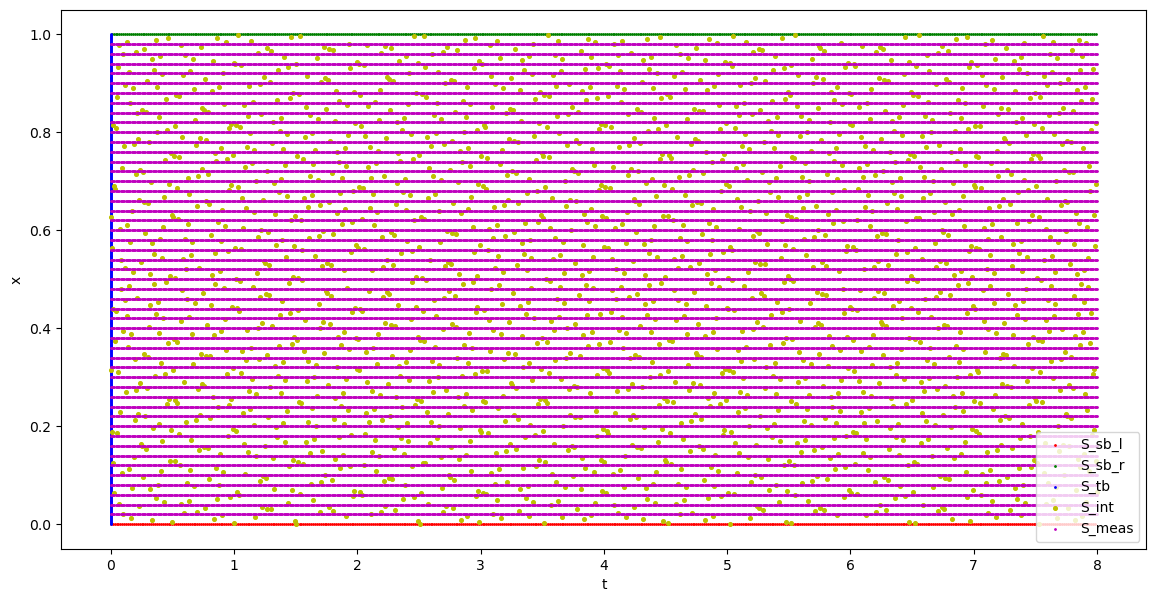

In [166]:
# Plot the training points
pinn_2.plot_training_points()

In [167]:
#trainig parameter 
n_epochs = 1
max_iter = 10000
optimizer_LBFGS = optim.LBFGS( pinn_2.approximate_Tf_Ts.parameters(),
    lr=float(0.5),
    max_iter=max_iter,
    max_eval=50000,
    history_size=150,
    line_search_fn="strong_wolfe",
    tolerance_change=1.0 * np.finfo(float).eps,
)

optimizer_ADAM = optim.Adam(pinn_2.approximate_Tf_Ts.parameters(), lr=float(0.001))

################################  0  ################################
Total loss:  2.1149 | PDE Loss:  1.9672 | Function Loss:  0.5747 | Meas Loss:  -0.0362
Total loss:  2.0626 | PDE Loss:  1.8947 | Function Loss:  0.5684 | Meas Loss:  -0.0644
Total loss:  1.7909 | PDE Loss:  1.3912 | Function Loss:  0.5701 | Meas Loss:  -0.2428
Total loss:  1.7115 | PDE Loss:  1.2852 | Function Loss:  0.5076 | Meas Loss:  -0.2518
Total loss:  1.4904 | PDE Loss:  0.5363 | Function Loss:  0.4393 | Meas Loss:  -0.1536
Total loss:  1.4582 | PDE Loss:  0.5078 | Function Loss:  0.4065 | Meas Loss:  -0.1645
Total loss:  1.4399 | PDE Loss:  0.471 | Function Loss:  0.3906 | Meas Loss:  -0.2046
Total loss:  1.3942 | PDE Loss:  0.3271 | Function Loss:  0.3553 | Meas Loss:  -0.2922
Total loss:  1.3593 | PDE Loss:  0.192 | Function Loss:  0.3287 | Meas Loss:  -0.3325
Total loss:  1.3257 | PDE Loss:  0.1407 | Function Loss:  0.2964 | Meas Loss:  -0.3471
Total loss:  1.2964 | PDE Loss:  0.1228 | Function Loss:  0.26

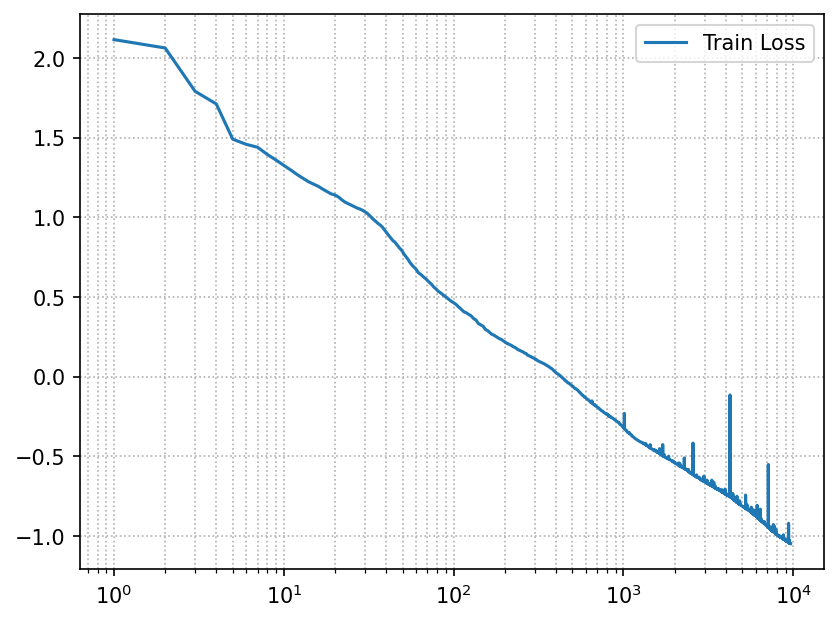

In [168]:
# Fit the model
hist = pinn_2.fit( num_epochs=n_epochs, optimizer=optimizer_LBFGS, verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

----------------------------------------------------
Parametes of the error for the Measured Data
----------------------------------------------------
L2 Relative Error Norm:  3.303729772567749 %
mean error:			 0.03537692502140999
std error:			 0.04853443801403046


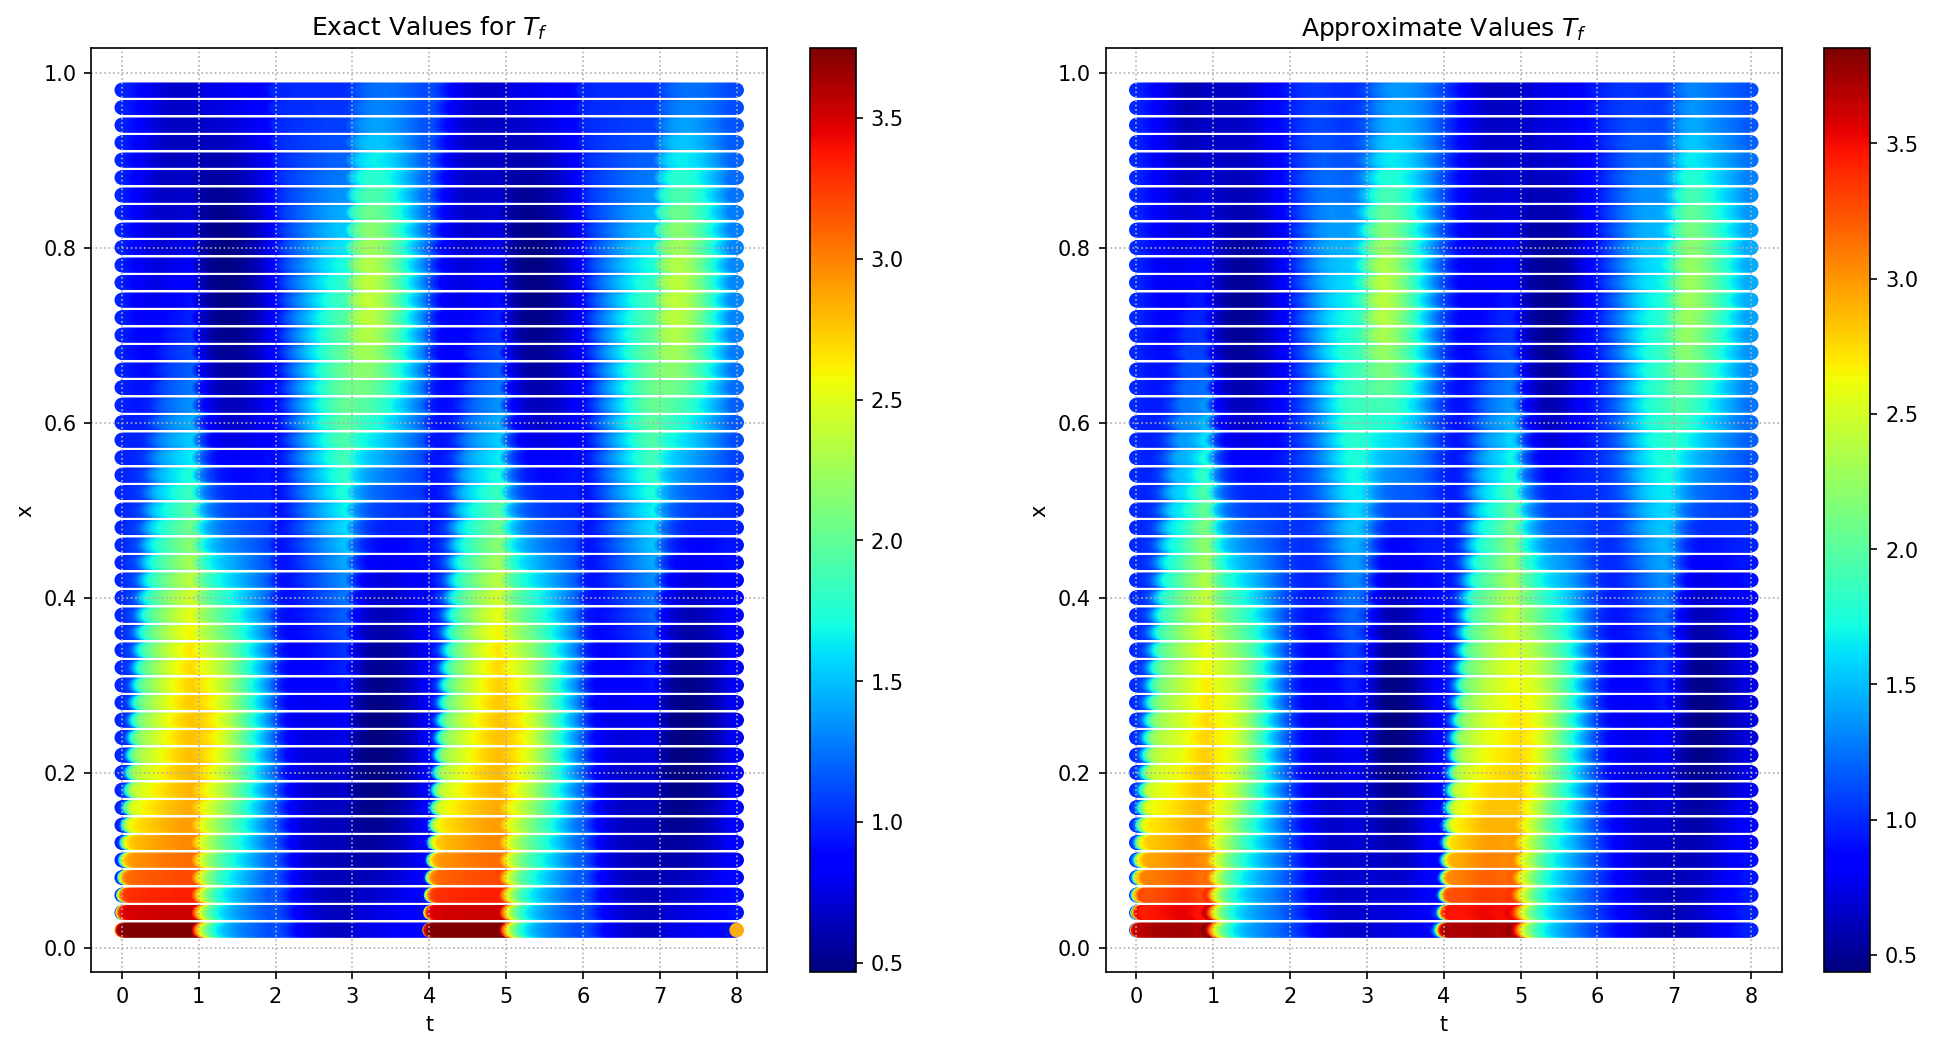

In [169]:
# Plot the solution for T_f (data vs prediction)
pinn_2.plot_solution()

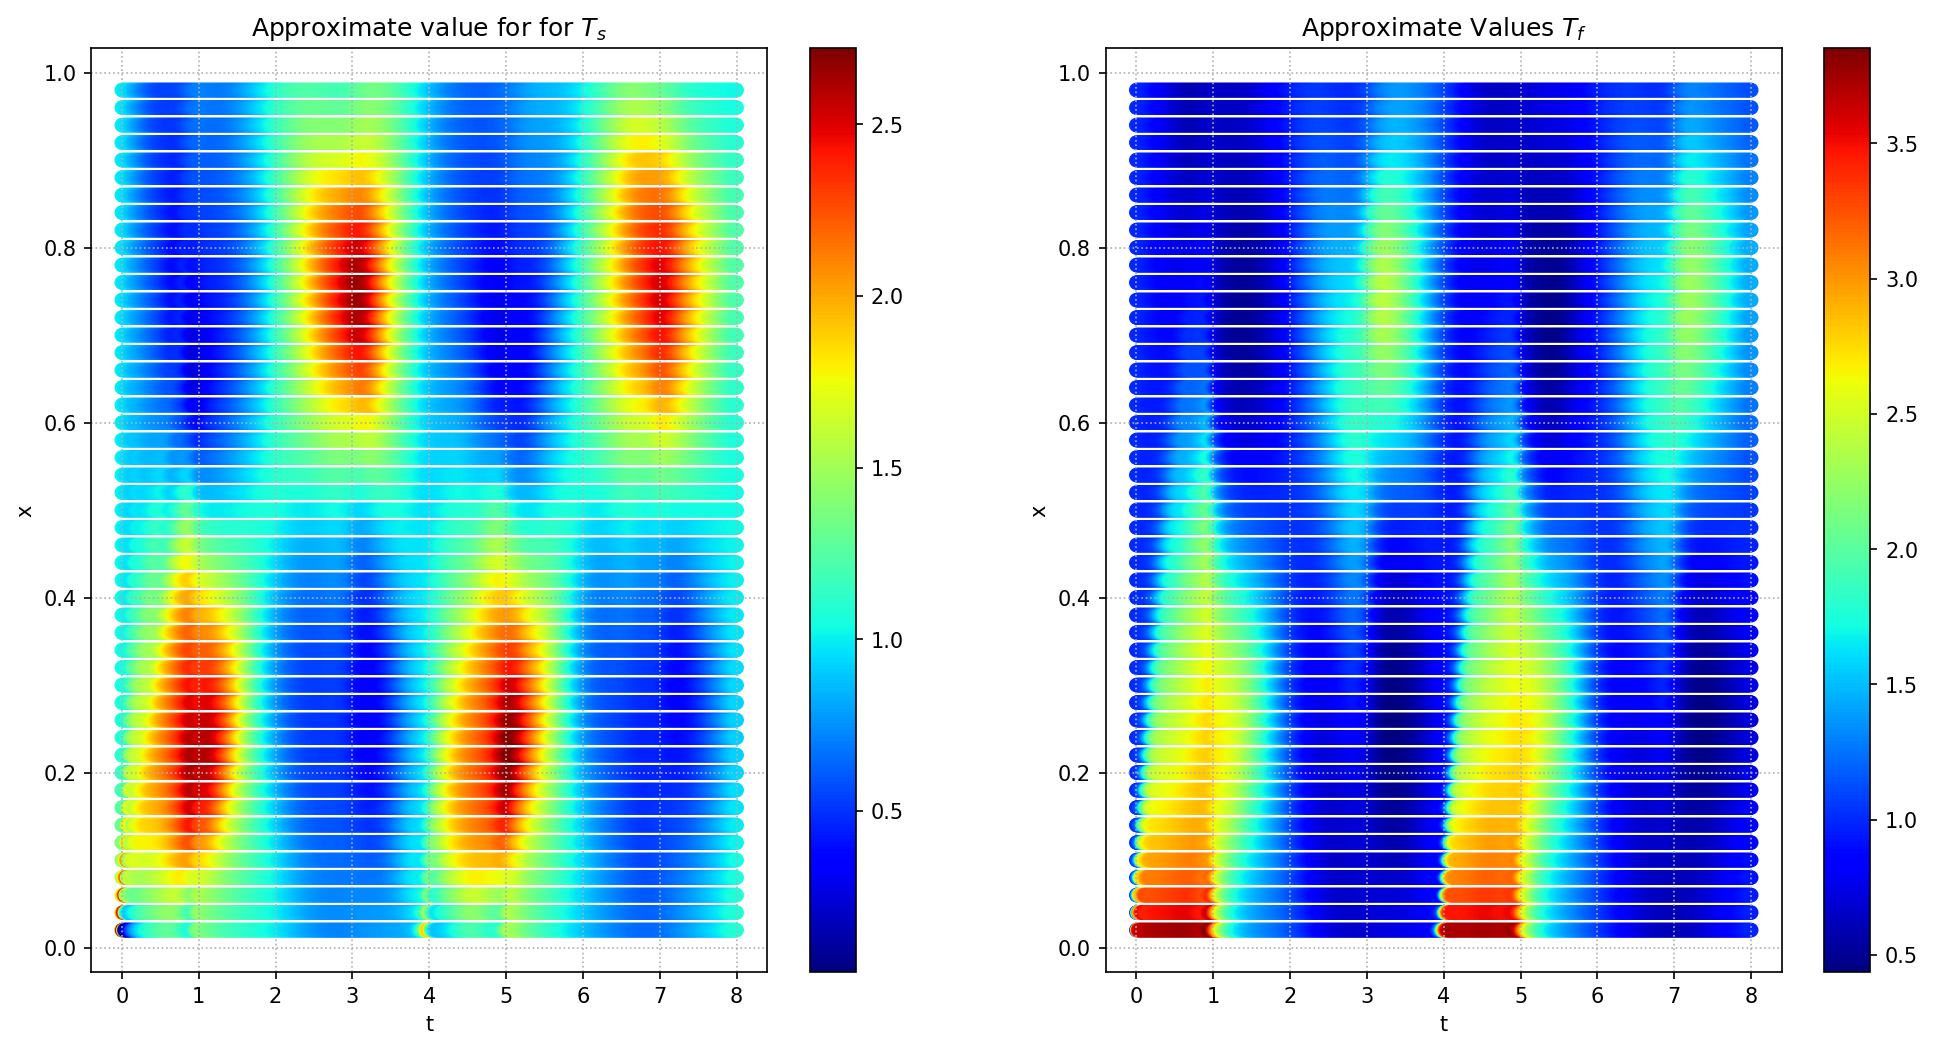

In [170]:
# plot function for Ts and Tf (approximated)

def plot_solution_2(self, n_points=10000):
    """
    plots solution T_f and compares with the measurements of T_f
    """

    input_meas, exact_meas = pinn_2.get_measurement_data()

    # Plot the predictions vs the exact solutions
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)

    prediction_meas_Ts = pinn_2.approximate_Tf_Ts(input_meas)[:, 1].reshape(
        -1,
    )
    
    im1 = axs[0].scatter(
        input_meas[:, 0].detach(),
        input_meas[:, 1].detach(),
        c=prediction_meas_Ts.detach(),
        cmap="jet",
    )
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("x")
    axs[0].set_title(r"Approximate value for for $T_s$")
    plt.colorbar(im1, ax=axs[0])
    axs[0].grid(True, which="both", ls=":")

    prediction_meas_Tf = pinn_2.approximate_Tf_Ts(input_meas)[:, 0].reshape(
        -1,
    )

    im2 = axs[1].scatter(
    input_meas[:, 0].detach(),
    input_meas[:, 1].detach(),
    c=prediction_meas_Tf.detach(),
    cmap="jet",
    )
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("x")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")

    axs[1].set_title(r"Approximate Values $T_f$")

    plt.show()


plot_solution_2(pinn_2)
    

In [174]:
#Here I save the resulting ts datapoints in a .txt file with the first row contains the headers t, x, ts
# the following rows contain the values of t, x, ts

test_data = pinn_2.get_measurement_data()[0]
test_data_Ts = pinn_2.approximate_Tf_Ts(test_data)[:, 1].detach().numpy()

def save_results(file_name, test_data, test_data_Ts):
    with open(file_name, "w") as f:
        f.write("t, x, ts\n")
        for i in range(len(test_data)):
            f.write(f"{test_data[i][0]}, {test_data[i][1]}, {test_data_Ts[i]}\n")


save_results(
    "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/AI in Science and Engineering /Proj1_Y24/Task2/Lorenzo_Tarricone_23946502_Task2.txt",
    test_data,
    test_data_Ts
)
